In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import json
from collections import Counter
# import numpy as np
import re

####################################################
# 1. Extend the model with a masking head (LM Head)
####################################################
class ESMCMasked(nn.Module):
   
    # A simple wrapper that takes a pre-trained ESM C model and adds
    # a masking (language modeling) head on top of the final hidden states.

    def __init__(self, base_model, hidden_dim=64, num_aa=33):
        super().__init__()
        self.base_model = base_model  # Pretrained ESM C model
        self.mask_head = nn.Linear(hidden_dim, num_aa)  # Simple linear LM head

    def forward(self, protein_obj, mask_positions=None):
        # Encode the protein to get initial embeddings
        encoded_seq = self.base_model.encode(protein_obj)
        # Obtain the hidden representations (logits call ensures forward pass)
        logits_out = self.base_model.logits(
            encoded_seq,
            LogitsConfig(sequence=True, return_embeddings=False)
        )
        # logits_out.logits.sequence is a list of length batch_size; here presumably 1
        # hidden has shape [L, hidden_dim] if single-sequence
        hidden = logits_out.logits.sequence[0]

        # Convert hidden from bfloat16 to float32 (match linear layer weights)
        hidden = hidden.to(self.mask_head.weight.dtype)

        # Pass through the custom LM head
        out_logits = self.mask_head(hidden)  # shape: [L, num_aa]

        if mask_positions is not None:
            # Return just the masked positions
            masked_logits = out_logits[mask_positions]
            return masked_logits, hidden
        else:
            # Or return logits for every position
            return out_logits

def load_finetuned_model(model_path, full_pretraining=False, device='cuda'):
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    config = checkpoint['config']
    
    # 1. Load base ESMC model
    base_model = ESMC.from_pretrained("esmc_300m").to(device)
    
    # 3. Wrap with ESMCMasked using saved config
    model = ESMCMasked(
        base_model,
        hidden_dim=config['hidden_dim'],
        num_aa=config['num_aa']
    ).to(device)
    
    # 4. Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [2]:
mave_df = pd.read_csv('/global/scratch/users/sergiomar10/data/MAVEDB/urn_mavedb_00000824-a-1_scores.csv')

In [3]:
def extract_mutation_info(x):
    m = re.match(r"p\.([A-Za-z]{3})(\d+)([A-Za-z]{3})", x)
    if m:
        return m.group(1), float(m.group(2)), m.group(3)
    return None, None, None

# Extract mutation information into separate columns
mut_info = mave_df['hgvs_pro'].apply(lambda x: pd.Series(extract_mutation_info(x)))
mut_info.columns = ['WT', 'POS', 'MT']

# Append the mutation info to the original dataframe
mave_df = pd.concat([mave_df, mut_info], axis=1)

# Filter out any rows without a valid position and sort by position
mave_df = mave_df[mave_df['POS'].notna()].sort_values(by='POS')

# Create the pivot table: rows are positions and columns are mutant amino acids,
# filling each cell with the corresponding 'score' value.
score_matrix = mave_df.pivot_table(index='POS', columns='MT', values='score', aggfunc='first')

# Ensure the matrix includes exactly the 79 positions and 20 amino acids.
# Define the expected positions (assuming positions 1.0 to 79.0) and amino acids.
expected_positions = sorted(mave_df['POS'].unique())
expected_aas = ["Ala", "Arg", "Asn", "Asp", "Cys", "Glu", "Gln", "Gly", 
                "His", "Ile", "Leu", "Lys", "Met", "Phe", "Pro", "Ser", 
                "Thr", "Trp", "Tyr", "Val"]

score_matrix = score_matrix.reindex(expected_positions)
score_matrix = score_matrix.reindex(columns=expected_aas)

# print(score_matrix)


In [4]:
score_matrix.index = mave_df[['WT','POS']].drop_duplicates(subset='POS').sort_values('POS')['WT'].values


In [5]:
mave_df[['WT','POS']].drop_duplicates(subset='POS').sort_values('POS')['WT'].values

array(['Gly', 'Tyr', 'Arg', 'Lys', 'Glu', 'Gln', 'Glu', 'Arg', 'Leu',
       'Gly', 'Ile', 'Pro', 'Tyr', 'Asp', 'Pro', 'Ile', 'Gln', 'Trp',
       'Ser', 'Thr', 'Asp', 'Gln', 'Val', 'Leu', 'His', 'Trp', 'Val',
       'Val', 'Trp', 'Val', 'Met', 'Lys', 'Glu', 'Phe', 'Ser', 'Met',
       'Thr', 'Asp', 'Ile', 'Asp', 'Leu', 'Thr', 'Thr', 'Leu', 'Asn',
       'Ile', 'Ser', 'Gly', 'Arg', 'Glu', 'Leu', 'Cys', 'Ser', 'Leu',
       'Asn', 'Gln', 'Glu', 'Asp', 'Phe', 'Phe', 'Gln', 'Arg', 'Val',
       'Pro', 'Arg', 'Gly', 'Glu', 'Ile', 'Leu', 'Trp', 'Ser', 'His',
       'Leu', 'Glu', 'Leu', 'Leu', 'Arg', 'Lys', 'Tyr'], dtype=object)

In [6]:
score_matrix = score_matrix.T

In [7]:
score_matrix

,Gly,Tyr,Arg,Lys,Glu,Gln,Glu,Arg,Leu,Gly,...,Trp,Ser,His,Leu,Glu,Leu,Leu,Arg,Lys,Tyr
MT,,,,,,,,,,,,,,,,,,,,,
Ala,-0.099932,NaN,-0.268339,-0.062543,-0.608490,-0.076339,-0.070631,-0.055502,-0.080096,-0.068316,...,-0.747710,-0.046248,-0.244296,-0.735567,-0.061039,-0.020130,-0.533934,-0.547245,-0.000240,-0.021215
Arg,0.090662,NaN,NaN,-0.028657,-0.912874,-0.650559,-0.141085,NaN,-0.046690,-0.085087,...,-0.525961,-0.034251,-0.294588,-0.814549,-0.058318,-0.011875,-0.676500,NaN,0.003319,-0.053889
Asn,NaN,-0.149702,-0.372523,-0.032133,-0.896674,-0.844265,-0.177448,-0.191322,-0.079581,0.028110,...,-0.765668,-0.114949,-0.059780,-0.979043,-0.226296,0.054516,NaN,-0.118895,0.096186,0.106689
Asp,-0.077483,NaN,-0.498926,-0.103763,-0.370602,-0.678437,0.030832,-0.184744,-0.368151,-0.195837,...,-0.803760,0.027249,-0.214049,NaN,-0.023235,-0.021642,-0.912989,-0.382485,0.022771,0.060046
Cys,-0.149067,-0.254531,-0.205612,-0.269714,-0.287691,-0.117959,-0.516338,-0.355012,0.006425,-0.078601,...,-0.792729,-0.167078,-0.318568,-0.979178,-0.137606,-0.035080,-0.118572,-0.255254,-0.071185,-0.060518
Glu,-0.164388,NaN,-0.004192,-0.071941,NaN,-0.259906,NaN,-0.053896,-0.117025,-0.096132,...,-0.800704,-0.020777,0.009123,-0.757935,NaN,0.024381,-0.521379,-0.359876,-0.049977,0.010420
Gln,-0.047494,NaN,-0.049891,-0.106257,-0.484981,NaN,-0.071887,-0.158028,0.016066,0.009554,...,-0.874947,0.009515,0.019493,-0.713452,-0.074559,-0.079509,-0.416251,-0.299334,-0.058511,0.006092
Gly,NaN,NaN,-0.175881,-0.065807,-0.669686,-0.724170,-0.314566,-0.362647,-0.373198,NaN,...,-0.842553,-0.009677,-0.474528,-0.936702,-0.065768,-0.132442,-0.950026,-0.514743,0.032998,0.030627
His,0.073146,0.041169,-0.097921,-0.002846,-0.354234,-0.851942,-0.297518,-0.209764,-0.081642,-0.069737,...,-0.493538,-0.028569,NaN,-0.830742,0.020926,0.030939,-0.317400,-0.069560,-0.014914,0.002470


In [8]:
# from esm.models.esmc import ESMC
# from esm.sdk.api import ESMProtein, LogitsConfig
# from esm.sdk.api import ESMProtein, LogitsConfig

# model = load_finetuned_model(
#     "/global/scratch/users/sergiomar10/models/esm_c/masking/fine_tuned/False-Full_pretraining_20000_seq_2.pt",
#     full_pretraining=False,  # Must match training setting!
#     device=device
# )
# model.eval()  # Set to evaluation mode"

/clusterfs/nilah/sergio/miniconda3/envs/ESMC2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 34239.22it/s]


ESMCMasked(
  (base_model): ESMC(
    (embed): Embedding(64, 960)
    (transformer): TransformerStack(
      (blocks): ModuleList(
        (0-29): 30 x UnifiedTransformerBlock(
          (attn): MultiHeadAttention(
            (layernorm_qkv): Sequential(
              (0): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
              (1): Linear(in_features=960, out_features=2880, bias=False)
            )
            (out_proj): Linear(in_features=960, out_features=960, bias=False)
            (q_ln): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
            (k_ln): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
            (rotary): RotaryEmbedding()
          )
          (ffn): Sequential(
            (0): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=960, out_features=5120, bias=False)
            (2): SwiGLU()
            (3): Linear(in_features=2560, out_features=960, bias=False)
          )
        )
      )
     

In [9]:
# #########################################################
# # 4. Define a mapping for the 20 standard amino acids
# #########################################################
# amino_acids = "ARNDCEQGHILKMFPSTWYV"

# # Map each amino acid to its tokenizer-assigned ID
# aa_to_idx = {
#     aa: model.base_model.tokenizer(text=aa).input_ids[1]  # index=1 to skip <cls> or start token
#     for aa in amino_acids
# }
# # Reverse mapping: token_id → amino acid
# idx_to_aa = {idx: aa for aa, idx in aa_to_idx.items()}

# print(f"aa_to_idx: {aa_to_idx}", flush=True)
# print(f"idx_to_aa: {idx_to_aa}", flush=True)

aa_to_idx: {'A': 5, 'R': 10, 'N': 17, 'D': 13, 'C': 23, 'E': 9, 'Q': 16, 'G': 6, 'H': 21, 'I': 12, 'L': 4, 'K': 15, 'M': 20, 'F': 18, 'P': 14, 'S': 8, 'T': 11, 'W': 22, 'Y': 19, 'V': 7}
idx_to_aa: {5: 'A', 10: 'R', 17: 'N', 13: 'D', 23: 'C', 9: 'E', 16: 'Q', 6: 'G', 21: 'H', 12: 'I', 4: 'L', 15: 'K', 20: 'M', 18: 'F', 14: 'P', 8: 'S', 11: 'T', 22: 'W', 19: 'Y', 7: 'V'}


In [11]:
import numpy as np

three_to_one = {
    "Ala": "A", "Arg": "R", "Asn": "N", "Asp": "D", "Cys": "C",
    "Glu": "E", "Gln": "Q", "Gly": "G", "His": "H", "Ile": "I",
    "Leu": "L", "Lys": "K", "Met": "M", "Phe": "F", "Pro": "P",
    "Ser": "S", "Thr": "T", "Trp": "W", "Tyr": "Y", "Val": "V"
}

# Create the wild-type sequence string in one-letter codes.
wt_seq_str = "".join(mave_df[['WT','POS']].drop_duplicates(subset='POS').sort_values('POS')['WT'].map(three_to_one))

# Process the wild-type sequence with the ESM model.
original_protein = ESMProtein(sequence=wt_seq_str)
original_tensor = model.base_model.encode(original_protein)
orig_token_ids = original_tensor.sequence

# Collect valid positions (ignoring start/end tokens)
orig_valid_positions = []
for pos in range(1, len(orig_token_ids) - 1):
    token_id = int(orig_token_ids[pos].item())
    token_str = model.base_model.tokenizer.decode([token_id]).strip()
    if token_str in aa_to_idx:
        orig_valid_positions.append(pos)
orig_valid_positions_tensor = torch.tensor(orig_valid_positions, device=device)

with torch.no_grad():
    orig_logits, _ = model(original_protein, mask_positions=orig_valid_positions_tensor)
# orig_logits has shape [L, 20] where L should equal len(wt_seq_str)
orig_ll = orig_logits  # Log likelihoods

# Define the standard 20 amino acids (ordered according to aa_to_idx)
std_aas = sorted(aa_to_idx.keys(), key=lambda x: aa_to_idx[x])
# Reorder the logits to follow the sorted order (columns correspond to std_aas)
orig_ll_matrix = orig_ll[:, [aa_to_idx[aa] for aa in std_aas]].cpu().numpy()

# Compute the LLR matrix by subtracting, at each position, the log likelihood of the WT amino acid.
LLR_matrix = np.zeros_like(orig_ll_matrix)
for i in range(orig_ll_matrix.shape[0]):
    wt_aa = wt_seq_str[i]
    wt_idx = std_aas.index(wt_aa)
    LLR_matrix[i, :] = orig_ll_matrix[i, :] - orig_ll_matrix[i, wt_idx]

# Optionally, create a DataFrame for better readability.
# Here the row index is labeled with position (1-indexed) and the corresponding WT amino acid.
LLR_df = pd.DataFrame(
    LLR_matrix, 
    index=[f"{i+1}_{wt}" for i, wt in enumerate(wt_seq_str)], 
    columns=std_aas
)


In [12]:
LLR_df = LLR_df.T

In [13]:
score_matrix.rename(index=three_to_one, columns=three_to_one, inplace=True)


In [14]:
score_matrix.reset_index(inplace=True)

In [15]:
LLR_df.reset_index(inplace=True)

In [16]:
LLR_df = LLR_df.sort_values(by='index').reset_index(drop=True)

In [17]:
score_matrix = score_matrix.sort_values(by='MT') #.iloc[10]['MT']

In [18]:
score_matrix_array = score_matrix.iloc[:, 1:].values.flatten()
LLR_df_array = LLR_df.iloc[:, 1:].values.flatten()

dms_scores = pd.DataFrame({'score_matrix': score_matrix_array, 'LLR_df': LLR_df_array})
dms_scores = dms_scores[dms_scores['score_matrix'].notna()]

In [19]:
LLR_df.to_csv('/global/scratch/users/sergiomar10/data/MAVEDB/LLR_df_array_GABPA.csv')
score_matrix.to_csv('/global/scratch/users/sergiomar10/data/MAVEDB/score_matrix_GABPA.csv')

In [2]:
LLR_df = pd.read_csv('/global/scratch/users/sergiomar10/data/MAVEDB/LLR_df_array_GABPA.csv')
score_matrix = pd.read_csv('/global/scratch/users/sergiomar10/data/MAVEDB/score_matrix_GABPA.csv')
LLR_df = LLR_df.iloc[:, 1:]
score_matrix = score_matrix.iloc[:, 1:]

   index       1_G       2_Y       3_R       4_K       5_E       6_Q  \
0      A -0.773088 -2.074124 -3.200257 -3.324859 -4.980749 -1.002223   
1      C -2.560433 -2.049939 -4.136982 -5.162133 -7.763490 -1.092048   
2      D  0.385675 -2.361170 -3.593430 -1.984618 -2.691058 -1.893903   
3      E  1.388642 -2.296736 -1.919340  0.024629  0.000000  0.555604   
4      F  0.153266  1.013491 -2.883411 -4.095408 -6.081308 -2.290403   
5      G  0.000000 -2.263513 -2.600213 -1.939366 -4.930645 -0.320375   
6      H -0.845693 -1.277627 -2.443420 -2.509303 -4.945466 -1.423772   
7      I -0.363173 -1.393410 -3.344016 -4.279001 -5.892975 -3.114987   
8      K -0.979650 -3.561917 -0.971102  0.000000 -4.136779 -0.289943   
9      L  0.474776 -0.269559 -1.705779 -3.161691 -5.328023 -1.332645   
10     M  2.543540 -1.276882 -2.404679 -2.792249 -4.724773 -0.906391   
11     N -1.488640 -2.862533 -2.956263 -2.337795 -5.001598 -1.071683   
12     P -0.691822 -2.577692 -3.391575 -3.758854 -6.605208 -2.45

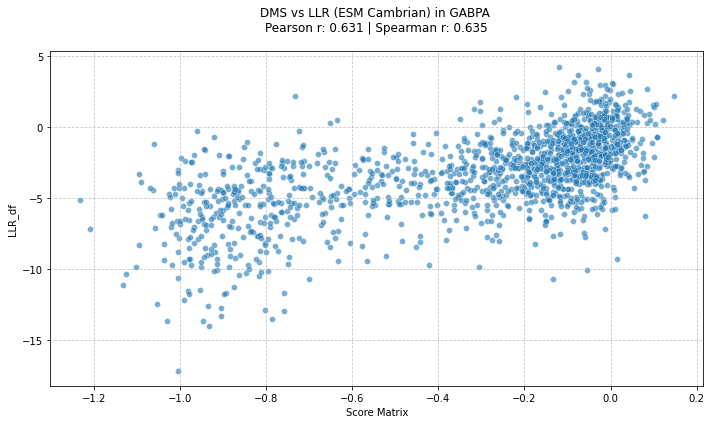

In [3]:
# print(score_matrix)# = score_matrix.iloc[:, 1:]

#    MT         G         Y         R         K         E         Q       E.1  \
# 0   A -0.099932       NaN -0.268339 -0.062543 -0.608490 -0.076339 -0.070631   
# 1   C -0.149067 -0.254531 -0.205612 -0.269714 -0.287691 -0.117959 -0.516338   
# 2   D -0.077483       NaN -0.498926 -0.103763 -0.370602 -0.678437  0.030832   
# 3   E -0.164388       NaN -0.004192 -0.071941       NaN -0.259906       NaN   
# 4   F       NaN -0.190795 -0.058066 -0.131475 -0.418639 -0.183634 -0.251760   
# 5   G       NaN       NaN -0.175881 -0.065807 -0.669686 -0.724170 -0.314566   
# 6   H  0.073146  0.041169 -0.097921 -0.002846 -0.354234 -0.851942 -0.297518   
# 7   I       NaN       NaN -0.016399  0.053558  0.004362  0.077573 -0.160531   
# 8   K       NaN       NaN -0.083470       NaN -0.806208 -0.959946 -0.493503   
# 9   L -0.634314       NaN -0.182186 -0.065086 -0.449537  0.036543 -0.187385   
# 10  M  0.045050       NaN -0.158191 -0.035053 -0.281289 -0.015451 -0.098157   
# 11  N       NaN -0.149702 -0.372523 -0.032133 -0.896674 -0.844265 -0.177448   
# 12  P       NaN       NaN -0.517375 -0.325657 -0.958444 -0.738709 -0.891007   
# 13  Q -0.047494       NaN -0.049891 -0.106257 -0.484981       NaN -0.071887   
# 14  R  0.090662       NaN       NaN -0.028657 -0.912874 -0.650559 -0.141085   
# 15  S -0.134923       NaN -0.214431 -0.025682 -0.741930 -0.221420 -0.162979   
# 16  T -0.156366       NaN -0.148924 -0.066779 -0.346577 -0.171726 -0.089860   
# 17  V -0.172721       NaN -0.261691 -0.044930 -0.093011 -0.069166 -0.171980   
# 18  W -0.505721       NaN -0.080576 -0.119944 -0.442054 -0.497877 -0.287933   
# 19  Y       NaN       NaN -0.190396 -0.100176 -0.148917 -0.700176 -0.282482   

#          R.1         L  ...       W.3       S.4       H.1       L.7       E.6  \
# 0  -0.055502 -0.080096  ... -0.747710 -0.046248 -0.244296 -0.735567 -0.061039   
# 1  -0.355012  0.006425  ... -0.792729 -0.167078 -0.318568 -0.979178 -0.137606   
# ...
# 18 -0.103506 -0.620959 -0.873168 -0.229642 -0.090258  
# 19  0.009572 -0.570910 -0.463319 -0.208344       NaN  


print(LLR_df) #= LLR_df.iloc[:, 1:]

#   index       1_G       2_Y       3_R       4_K       5_E       6_Q  \
# 0      A -0.773088 -2.074124 -3.200257 -3.324859 -4.980749 -1.002223   
# 1      C -2.560433 -2.049939 -4.136982 -5.162133 -7.763490 -1.092048   
# 2      D  0.385675 -2.361170 -3.593430 -1.984618 -2.691058 -1.893903   
# 3      E  1.388642 -2.296736 -1.919340  0.024629  0.000000  0.555604   
# 4      F  0.153266  1.013491 -2.883411 -4.095408 -6.081308 -2.290403   
# 5      G  0.000000 -2.263513 -2.600213 -1.939366 -4.930645 -0.320375   
# 6      H -0.845693 -1.277627 -2.443420 -2.509303 -4.945466 -1.423772   
# 7      I -0.363173 -1.393410 -3.344016 -4.279001 -5.892975 -3.114987   
# 8      K -0.979650 -3.561917 -0.971102  0.000000 -4.136779 -0.289943   
# 9      L  0.474776 -0.269559 -1.705779 -3.161691 -5.328023 -1.332645   
# 10     M  2.543540 -1.276882 -2.404679 -2.792249 -4.724773 -0.906391   
# 11     N -1.488640 -2.862533 -2.956263 -2.337795 -5.001598 -1.071683   
# 12     P -0.691822 -2.577692 -3.391575 -3.758854 -6.605208 -2.456442   
# 13     Q -0.848850 -2.877319 -1.672083 -1.366750 -3.794031  0.000000   
# 14     R  0.507909 -1.330983  0.000000  0.178339 -4.377014  0.229489   
# 15     S -1.135813 -2.307431 -2.925979 -2.913914 -5.401619 -0.453185   
# 16     T -1.013455 -3.507180 -3.128124 -3.379253 -5.173640 -1.481879   
# 17     V -0.478829 -1.017500 -3.045349 -3.533720 -5.231423 -1.572434   
# 18     W -2.132601 -1.931857 -3.944097 -4.900303 -7.679010 -3.687127   
# 19     Y -1.142432  0.000000 -4.040017 -4.778608 -6.608036 -2.784925   

#          7_E       8_R       9_L  ...      70_W      71_S      72_H  \
# 0  -3.235576 -4.030741 -3.633891  ... -4.801788 -0.392996 -3.734358   
# 1  -5.418842 -4.797381 -4.249121  ... -3.330037 -2.920450 -3.490565   
# ...
# 18  -3.922693 -7.114163 -3.772664  -5.535238 -4.365800 -3.474051  0.466095  
# 19  -4.532503 -4.747745 -2.753167  -4.719082 -5.326951 -3.466590  0.000000  

# [20 rows x 80 columns]

score_matrix_array = score_matrix.iloc[:, 1:].values.flatten()
LLR_df_array = LLR_df.iloc[:, 1:].values.flatten()

dms_scores = pd.DataFrame({'score_matrix': score_matrix_array, 'LLR_df': LLR_df_array})
dms_scores = dms_scores[dms_scores['score_matrix'].notna()]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Remove NaN values for correlation calculation
dms_scores_clean = dms_scores.dropna()

# Calculate correlations
pearson_corr, _ = pearsonr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])
spearman_corr, _ = spearmanr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dms_scores, x='score_matrix', y='LLR_df', alpha=0.6)

# Customize the plot
plt.title(f'DMS vs LLR (ESM Cambrian) in GABPA \n'
          f'Pearson r: {pearson_corr:.3f} | Spearman r: {spearman_corr:.3f}',
          pad=20)
plt.xlabel('Score Matrix')
plt.ylabel('LLR_df')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
plt.show()

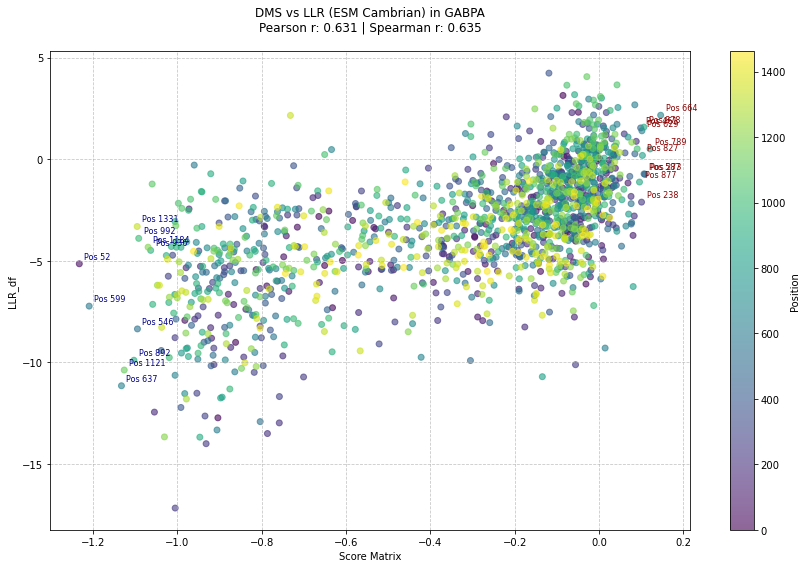

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Assuming score_matrix is already defined as in your example
score_matrix_array = score_matrix.iloc[:, 1:].values.flatten()
LLR_df_array = LLR_df.iloc[:, 1:].values.flatten()  # Assuming LLR_df exists

dms_scores = pd.DataFrame({'score_matrix': score_matrix_array, 'LLR_df': LLR_df_array})
dms_scores = dms_scores[dms_scores['score_matrix'].notna()]

# Remove NaN values for correlation calculation
dms_scores_clean = dms_scores.dropna()

# Calculate correlations
pearson_corr, _ = pearsonr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])
spearman_corr, _ = spearmanr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])

# Add position information
dms_scores_clean['position'] = range(len(dms_scores_clean))

# Create the scatterplot with color by position
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data=dms_scores_clean, 
                     x='score_matrix', 
                     y='LLR_df', 
                     c='position',  # Color by position
                     cmap='viridis',  # Color map
                     alpha=0.6)

# Add colorbar
plt.colorbar(scatter, label='Position')

# Identify top and bottom 10 points based on score_matrix
top_10 = dms_scores_clean.nlargest(10, 'score_matrix')
bottom_10 = dms_scores_clean.nsmallest(10, 'score_matrix')

# Annotate top 10 points
for idx, row in top_10.iterrows():
    plt.annotate(f'Pos {int(row["position"])}', 
                (row['score_matrix'], row['LLR_df']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                color='darkred')

# Annotate bottom 10 points
for idx, row in bottom_10.iterrows():
    plt.annotate(f'Pos {int(row["position"])}', 
                (row['score_matrix'], row['LLR_df']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                color='darkblue')

# Customize the plot
plt.title(f'DMS vs LLR (ESM Cambrian) in GABPA\n'
          f'Pearson r: {pearson_corr:.3f} | Spearman r: {spearman_corr:.3f}',
          pad=20)
plt.xlabel('Score Matrix')
plt.ylabel('LLR_df')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

       'D', 'P.1', 'I.1', 'Q.1', 'W', 'S', 'T', 'D.1', 'Q.2', 'V', 'L.1', 'H',
       'W.1', 'V.1', 'V.2', 'W.2', 'V.3', 'M', 'K.1', 'E.2', 'F', 'S.1', 'M.1',
       'T.1', 'D.2', 'I.2', 'D.3', 'L.2', 'T.2', 'T.3', 'L.3', 'N', 'I.3',
       'S.2', 'G.2', 'R.2', 'E.3', 'L.4', 'C', 'S.3', 'L.5', 'N.1', 'Q.3',
       'E.4', 'D.4', 'F.1', 'F.2', 'Q.4', 'R.3', 'V.4', 'P.2', 'R.4', 'G.3',
       'E.5', 'I.4', 'L.6', 'W.3', 'S.4', 'H.1', 'L.7', 'E.6', 'L.8', 'L.9',
       'R.5', 'K.2', 'Y.2'],
      dtype='object'). Using sequential indices (0 to 78) instead. Check your position headers.


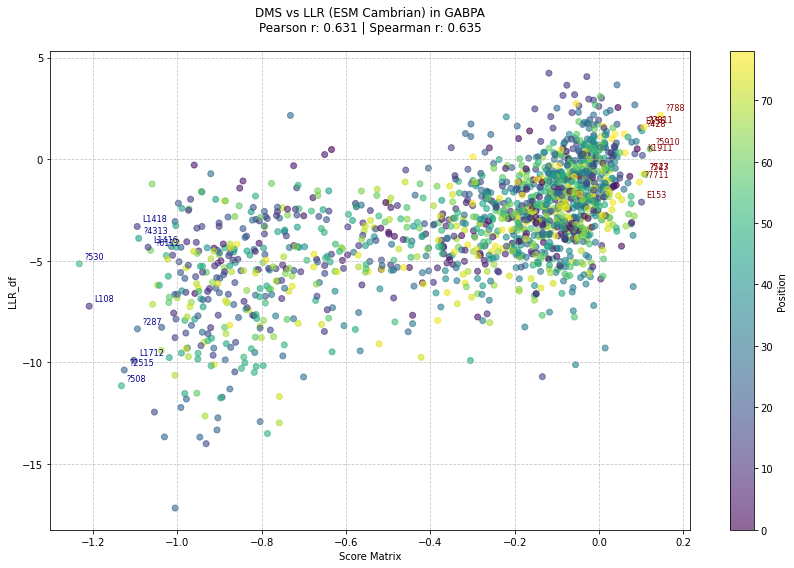

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Assuming score_matrix is already defined as in your example
score_matrix_array = score_matrix.iloc[:, 1:].values.flatten()
LLR_df_array = LLR_df.iloc[:, 1:].values.flatten()  # Assuming LLR_df exists

dms_scores = pd.DataFrame({'score_matrix': score_matrix_array, 'LLR_df': LLR_df_array})
dms_scores = dms_scores[dms_scores['score_matrix'].notna()]

# Remove NaN values for correlation calculation
dms_scores_clean = dms_scores.dropna()

# Calculate correlations
pearson_corr, _ = pearsonr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])
spearman_corr, _ = spearmanr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])

# Extract residue information from the original DataFrame structure
amino_acids = score_matrix.index  # Row indices (A, C, D, etc.)
positions = score_matrix.columns[1:]  # Column headers (0, 4, 3, etc.), excluding the amino acid column
wild_type = ['M', 'T', 'G', 'Y', 'R', 'K', 'E', 'Q', 'E', 'R', 'L', 'W', 'S', 'H', 'L', 'E', 'L', 'L', 'R', 'K', 'Y']  # Verify this sequence

# Verify positions match wild_type length
numeric_positions = [int(pos) for pos in positions if pos.isdigit()]
if numeric_positions:  # Check if there are any numeric positions
    max_position = max(numeric_positions)
else:
    # Fallback: assume positions are sequential indices (0, 1, 2, ...) or use column indices
    max_position = len(positions) - 1  # Use the number of columns as max position
    print(f"Warning: No numeric positions found in {positions}. Using sequential indices (0 to {max_position}) instead. Check your position headers.")

if max_position >= len(wild_type):
    print(f"Warning: Position {max_position} exceeds wild_type length ({len(wild_type)}). Check wild_type sequence or position mapping.")
    wild_type.extend(['?'] * (max_position - len(wild_type) + 1))  # Extend with placeholders if needed

# Create residue labels and position list
residue_labels = []
position_list = []
for i, aa in enumerate(amino_acids):
    for j, pos in enumerate(positions):
        if not np.isnan(score_matrix.iloc[i, j + 1]):  # +1 to skip the amino acid column
            try:
                pos_num = int(pos) if pos.isdigit() else j  # Use column value if numeric, else use column index
            except (ValueError, TypeError):
                pos_num = j  # Fallback to column index if parsing fails
            # Ensure pos_num is within bounds
            if pos_num < len(wild_type):
                wt_aa = wild_type[pos_num]
            else:
                wt_aa = '?'  # Fallback for out-of-bounds positions
            residue_labels.append(f"{wt_aa}{pos_num}{aa}")  # Format as "WildTypePositionMutant" (e.g., "A83R")
            position_list.append(pos_num)  # Store the actual position

# Add residue labels and positions to the cleaned dataframe
dms_scores_clean['residue'] = residue_labels[:len(dms_scores_clean)]  # Match length
dms_scores_clean['position'] = position_list[:len(dms_scores_clean)]  # Use actual positions

# Create the scatterplot with color by position
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data=dms_scores_clean, 
                     x='score_matrix', 
                     y='LLR_df', 
                     c='position',  # Color by actual position
                     cmap='viridis', 
                     alpha=0.6)

# Add colorbar
plt.colorbar(scatter, label='Position')

# Identify top and bottom 10 points based on score_matrix
top_10 = dms_scores_clean.nlargest(10, 'score_matrix')
bottom_10 = dms_scores_clean.nsmallest(10, 'score_matrix')

# Annotate top 10 points with residue labels
for idx, row in top_10.iterrows():
    plt.annotate(row['residue'], 
                (row['score_matrix'], row['LLR_df']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                color='darkred')

# Annotate bottom 10 points with residue labels
for idx, row in bottom_10.iterrows():
    plt.annotate(row['residue'], 
                (row['score_matrix'], row['LLR_df']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                color='darkblue')

# Customize the plot
plt.title(f'DMS vs LLR (ESM Cambrian) in GABPA\n'
          f'Pearson r: {pearson_corr:.3f} | Spearman r: {spearman_corr:.3f}',
          pad=20)
plt.xlabel('Score Matrix')
plt.ylabel('LLR_df')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

/tmp/ipykernel_82487/2792107117.py:96: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


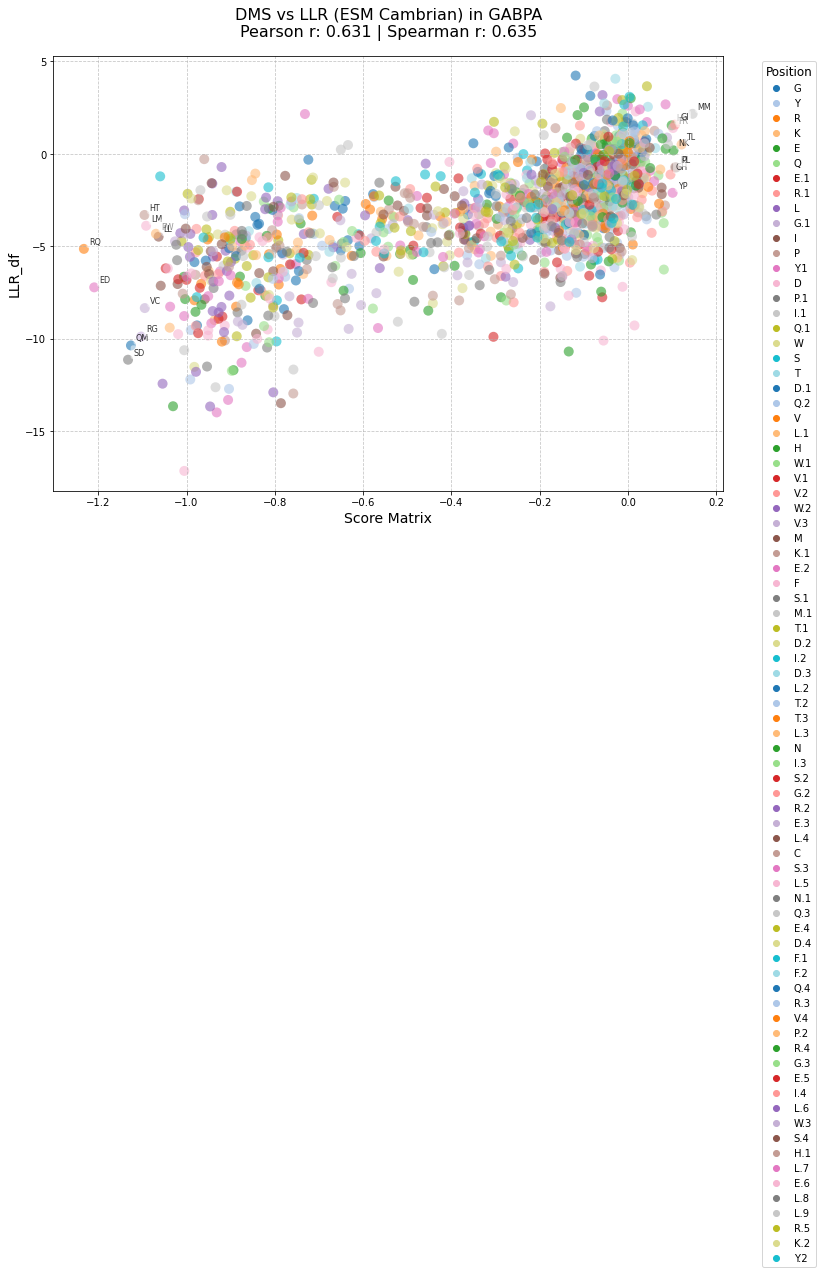

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Assuming score_matrix and LLR_df are your DataFrames
score_matrix_array = score_matrix.iloc[:, 1:].values.flatten()
LLR_df_array = LLR_df.iloc[:, 1:].values.flatten()

# Create DataFrame
dms_scores = pd.DataFrame({'score_matrix': score_matrix_array, 'LLR_df': LLR_df_array})

# Extract position and residue information
positions = score_matrix.columns[1:]  # e.g., 'MT', 'G', 'W.3'
residues = score_matrix.iloc[:, 0]   # e.g., 'A', 'C', 'D' (mutated residues)
n_rows = score_matrix.shape[0]

# Repeat positions for each residue
position_labels = np.repeat(positions, n_rows)

# Tile residues for each position
residue_labels = np.tile(residues, len(positions))

# Add to DataFrame
dms_scores['position'] = position_labels
dms_scores['mutant'] = residue_labels

# Remove NaN rows
dms_scores_clean = dms_scores.dropna(subset=['score_matrix', 'LLR_df'])

# Calculate correlations
pearson_corr, _ = pearsonr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])
spearman_corr, _ = spearmanr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])

# Sort by score_matrix to get top and bottom 10
dms_scores_sorted = dms_scores_clean.sort_values('score_matrix')
top_10 = dms_scores_sorted.tail(10)
bottom_10 = dms_scores_sorted.head(10)
annotated_points = pd.concat([top_10, bottom_10])

# Infer WT from position (simplified: assumes position name might contain WT, e.g., 'W.3' -> 'W')
# This is a heuristic; adjust based on your data structure
def infer_wt(position):
    # If position like 'W.3', take first letter; otherwise, use a placeholder
    return position[0] if '.' in position or len(position) > 1 else position

annotated_points['wt'] = annotated_points['position'].apply(infer_wt)
annotated_points['annotation'] = annotated_points['wt'] + annotated_points['mutant']

# Create the scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=dms_scores_clean,
    x='score_matrix',
    y='LLR_df',
    hue='position',
    palette='tab20',
    alpha=0.6,
    s=100,
    edgecolor='none'
)

# Add annotations for top and bottom 10
for i, row in annotated_points.iterrows():
    plt.annotate(
        row['annotation'],
        (row['score_matrix'], row['LLR_df']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        alpha=0.8,
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.5)
    )

# Customize the plot
plt.title(
    f'DMS vs LLR (ESM Cambrian) in GABPA\n'
    f'Pearson r: {pearson_corr:.3f} | Spearman r: {spearman_corr:.3f}',
    fontsize=16,
    pad=20
)
plt.xlabel('Score Matrix', fontsize=14)
plt.ylabel('LLR_df', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust legend
plt.legend(
    title='Position',
    title_fontsize=12,
    fontsize=10,
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.savefig('dms_vs_llr_scatter_annotated.png', dpi=300, bbox_inches='tight')
plt.show()

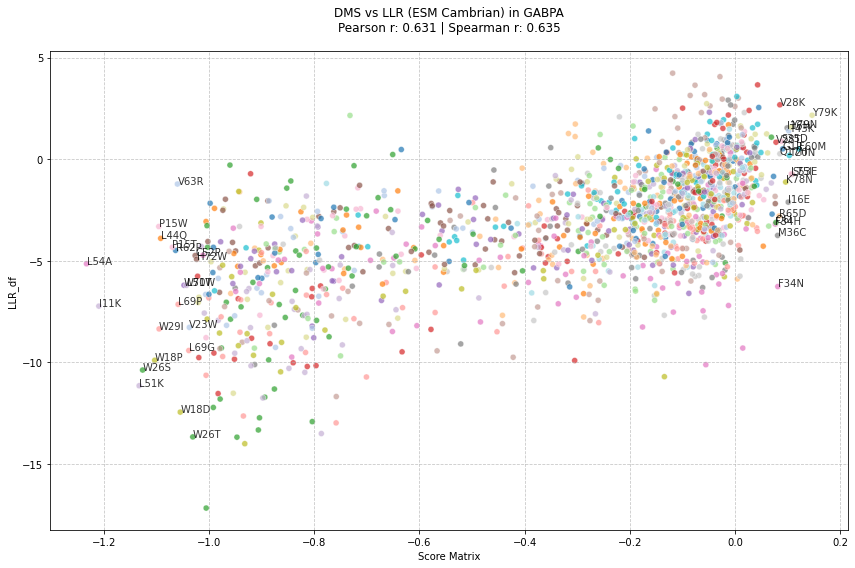

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

# --- Prepare data ---

# Assume 'score_matrix' and 'LLR_df' are your dataframes.
# The first column in each contains the mutant letter (e.g. A, C, D, …)
# and the remaining columns are the positions.
# For LLR_df the column names are like "1_G", "2_Y", etc.

# Get the numeric data arrays (excluding the first column)
score_vals = score_matrix.iloc[:, 1:].values
LLR_vals   = LLR_df.iloc[:, 1:].values

# Get mutant labels (from the first column of score_matrix)
mutant_labels = score_matrix.iloc[:, 0].values  # shape (n_rows,)
n_rows, n_cols = score_vals.shape

# Create an array of mutant labels repeated for each position
mutants_repeated = np.repeat(mutant_labels, n_cols)

# Get the position labels from LLR_df (using these since they include both position number and wild‐type)
position_labels = LLR_df.columns[1:].values  # e.g. ["1_G", "2_Y", ...]
positions_tiled = np.tile(position_labels, n_rows)

# Flatten the score and LLR values to create one long vector per metric
score_flat = score_vals.flatten()
LLR_flat   = LLR_vals.flatten()

# Build a combined DataFrame
dms_scores = pd.DataFrame({
    'mutant':       mutants_repeated,
    'position':     positions_tiled,
    'score_matrix': score_flat,
    'LLR_df':       LLR_flat
})

# Remove rows with NaN values (in one or both metrics)
dms_scores = dms_scores.dropna(subset=['score_matrix', 'LLR_df'])

# --- Create annotation strings ---
# Here we assume that the position column is of the form "number_wt"
# and we want to annotate each point as: wild-type + position number + mutant.
# For example, if position is "29_W" and mutant is "T", the annotation becomes "W29T".
def create_annotation(row):
    if '_' in row['position']:
        pos_num, wt = row['position'].split('_')
        return f"{wt}{pos_num}{row['mutant']}"
    else:
        return row['position']

dms_scores['annotation'] = dms_scores.apply(create_annotation, axis=1)

# --- Calculate correlations ---
pearson_corr, _ = pearsonr(dms_scores['score_matrix'], dms_scores['LLR_df'])
spearman_corr, _ = spearmanr(dms_scores['score_matrix'], dms_scores['LLR_df'])

# --- Create the scatter plot ---
plt.figure(figsize=(12, 8))

# Plot points and color them by the 'position' category.
# (For many positions you might wish to disable the legend or choose a different palette.)
sns.scatterplot(data=dms_scores, x='score_matrix', y='LLR_df',
                hue='position', palette='tab20', alpha=0.7, legend=False)

# Annotate each point with its mutation label.
for _, row in dms_scores.nlargest(20, 'score_matrix').iterrows():
    plt.text(row['score_matrix'], row['LLR_df'], row['annotation'],
             fontsize=10, alpha=0.8)

for _, row in dms_scores.nsmallest(20, 'score_matrix').iterrows():
    plt.text(row['score_matrix'], row['LLR_df'], row['annotation'],
             fontsize=10, alpha=0.8)


# # Identify top and bottom 10 points based on score_matrix
# top_10 = dms_scores_clean.nlargest(10, 'score_matrix')
# bottom_10 = dms_scores_clean.nsmallest(10, 'score_matrix')

# # Annotate top 10 points with residue labels
# for idx, row in top_10.iterrows():
#     plt.annotate(row['residue'], 
#                 (row['score_matrix'], row['LLR_df']),
#                 xytext=(5, 5),
#                 textcoords='offset points',
#                 fontsize=8,
#                 color='darkred')

# # Annotate bottom 10 points with residue labels
# for idx, row in bottom_10.iterrows():
#     plt.annotate(row['residue'], 
#                 (row['score_matrix'], row['LLR_df']),
#                 xytext=(5, 5),
#                 textcoords='offset points',
#                 fontsize=8,
#                 color='darkblue')


# Customize the plot
plt.title(f'DMS vs LLR (ESM Cambrian) in GABPA\n'
          f'Pearson r: {pearson_corr:.3f} | Spearman r: {spearman_corr:.3f}',
          pad=20)
plt.xlabel('Score Matrix')
plt.ylabel('LLR_df')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [92]:
result_df['classification'].unique()

array(['Likely_benign', 'Pathogenic', 'Benign', 'Likely_pathogenic', nan,
       'Benign/Likely_benign',
       'Conflicting_interpretations_of_pathogenicity',
       'Pathogenic/Likely_pathogenic', 'risk_factor', 'not_provided',
       'association'], dtype=object)

In [96]:
print(result_df[ (result_df['classification'].notna())])

            protein     classification          mc  mutation_position  \
0     SAMD11:148398      Likely_benign    missense               56.0   
1     SAMD11:148398         Pathogenic    nonsense                NaN   
2     SAMD11:148398             Benign    missense              666.0   
3       NOC2L:26155             Benign  synonymous                NaN   
4       NOC2L:26155             Benign  synonymous                NaN   
...             ...                ...         ...                ...   
1995      MTOR:2475      Likely_benign  synonymous                NaN   
1996      MTOR:2475  Likely_pathogenic    missense             2406.0   
1997      MTOR:2475             Benign  synonymous                NaN   
1998      MTOR:2475      Likely_benign  synonymous                NaN   
1999      MTOR:2475      Likely_benign  synonymous                NaN   

                                mutant_protein_sequence  \
0     MSKGILQVHPPICDCPGCRISSPVNRGRLADKRTVALPAARNLKKE...   
1    

In [94]:
Counter(result_df['classification'])

Counter({'Likely_benign': 930,
         'Benign': 500,
         'Conflicting_interpretations_of_pathogenicity': 140,
         'Pathogenic': 119,
         'Benign/Likely_benign': 113,
         nan: 100,
         'Likely_pathogenic': 70,
         'Pathogenic/Likely_pathogenic': 15,
         'not_provided': 10,
         'risk_factor': 2,
         'association': 1})

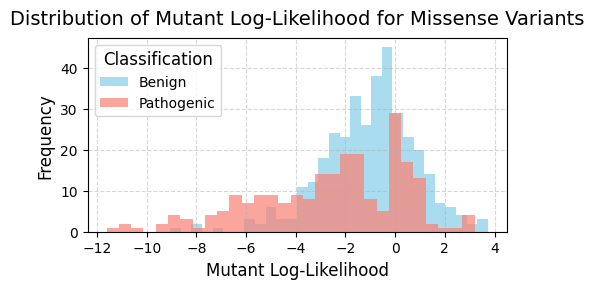

In [122]:
import matplotlib.pyplot as plt

# Filter the DataFrame for benign and pathogenic missense variants
benign_filter = (
    result_df['classification'].str.contains('enign', case=False, na=False) & 
    result_df['mc'].str.contains('missense', case=False, na=False)
)
pathogenic_filter = (
    result_df['classification'].str.contains('Patho', case=False, na=False) & 
    result_df['mc'].str.contains('missense', case=False, na=False)
)

# Extract the delta_log_likelihood values
benign_data = result_df[benign_filter]['delta_log_likelihood'].dropna()
pathogenic_data = result_df[pathogenic_filter]['delta_log_likelihood'].dropna()

# Create the histogram plot
plt.figure(figsize=(5, 3))  # Larger figure size for readability
plt.hist(benign_data, bins=30, alpha=0.7, label='Benign', color='skyblue') #, edgecolor='black')
plt.hist(pathogenic_data, bins=30, alpha=0.7, label='Pathogenic', color='salmon') #, edgecolor='black')

# Customize the plot
plt.title('Distribution of Mutant Log-Likelihood for Missense Variants', fontsize=14, pad=10)
plt.xlabel('Mutant Log-Likelihood', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Classification', fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  # Light grid for reference

# Adjust layout and display
plt.tight_layout()
plt.show()

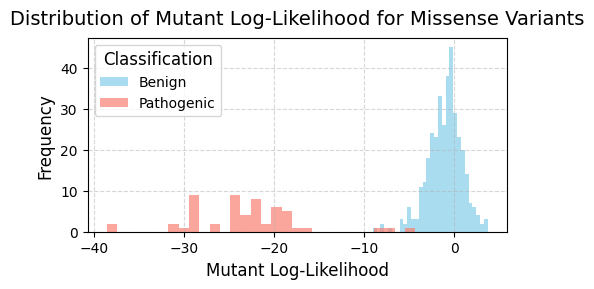

In [123]:
import matplotlib.pyplot as plt

# Filter the DataFrame for benign and pathogenic missense variants
benign_filter = (
    result_df['classification'].str.contains('enign', case=False, na=False) & 
    result_df['mc'].str.contains('missense', case=False, na=False)
)
pathogenic_filter = ( 
    result_df['classification'].str.contains('atho', case=False, na=False) & 
    result_df['mc'].str.contains('nonsense', case=False, na=False) &
    result_df['stop_gain_effect_score'].notna()
)

# Extract the delta_log_likelihood values
benign_data = result_df[benign_filter]['delta_log_likelihood'].dropna()
pathogenic_data = result_df[pathogenic_filter]['stop_gain_effect_score'].dropna()

# Create the histogram plot
plt.figure(figsize=(5, 3))  # Larger figure size for readability
plt.hist(benign_data, bins=30, alpha=0.7, label='Benign', color='skyblue' )#, edgecolor='black')
plt.hist(pathogenic_data, bins=30, alpha=0.7, label='Pathogenic', color='salmon') #, edgecolor='black')

# Customize the plot
plt.title('Distribution of Mutant Log-Likelihood for Missense Variants', fontsize=14, pad=10)
plt.xlabel('Mutant Log-Likelihood', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Classification', fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  # Light grid for reference

# Adjust layout and display
plt.tight_layout()
plt.show()

In [102]:
import seaborn as sns

/tmp/ipykernel_333605/2027094953.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='classification_grouped', y='delta_log_likelihood', data=missense_df,


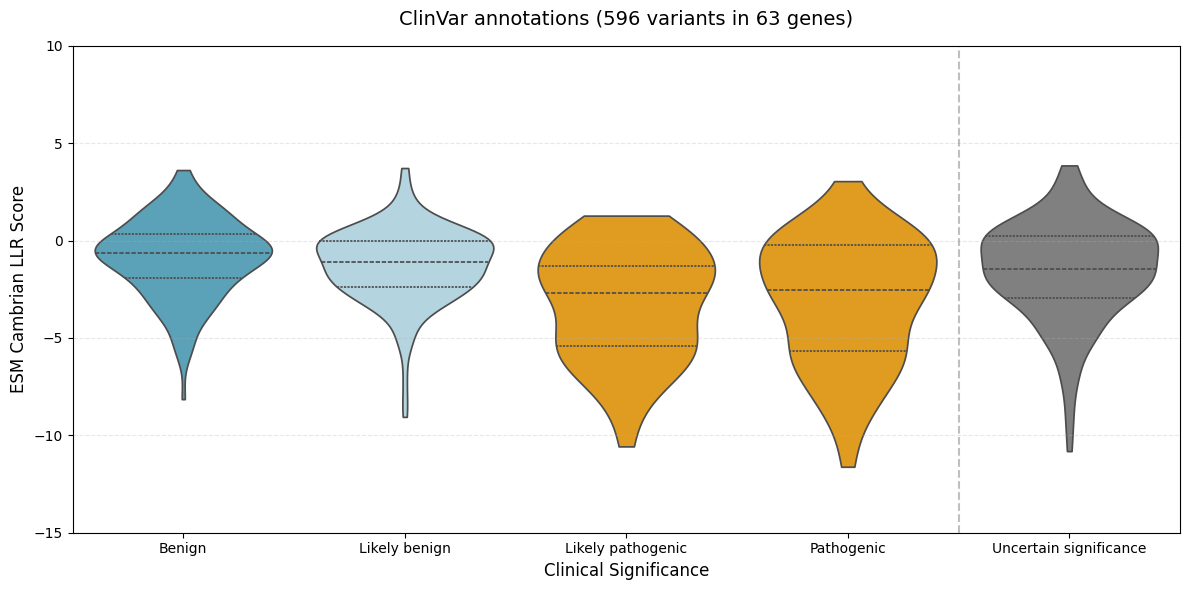

In [116]:
# Filter for missense variants and drop NaN values in delta_log_likelihood
missense_df = result_df[result_df['mc'] == 'missense'].dropna(subset=['delta_log_likelihood'])

# Map classifications to match the study's categories
classification_mapping = {
    'Benign': 'Benign',
    'Likely_benign': 'Likely benign',
    'Pathogenic': 'Pathogenic',
    'Likely_pathogenic': 'Likely pathogenic',
    # Combine Benign/Likely benign and Pathogenic/Likely pathogenic if needed
    'Conflicting_interpretations_of_pathogenicity': 'Uncertain significance'
}
missense_df['classification'] = missense_df['classification'].map(classification_mapping).fillna('Uncertain significance')

# Group similar classifications for the plot (optional, depending on data)
missense_df['classification_grouped'] = missense_df['classification'].replace({
    'Benign': 'Benign',
    'Likely benign': 'Likely benign',
    'Pathogenic': 'Pathogenic',
    'Likely pathogenic': 'Likely pathogenic',
    'Uncertain significance': 'Uncertain significance'
})

# Define custom colors matching the study (blue for benign, orange for pathogenic, gray for uncertain)
palette = {
    'Benign': '#4ba9c8',  # Light blue
    'Likely benign': '#ADD8E6',  # Light blue
    'Pathogenic': '#FFA500',  # Light orange
    'Likely pathogenic': '#FFA500',  # Light orange
    'Uncertain significance': '#808080'  # Gray
}

order = ['Benign', 'Likely benign', 'Likely pathogenic', 'Pathogenic', 'Uncertain significance']


# Set up the plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='classification_grouped', y='delta_log_likelihood', data=missense_df, 
               palette=palette, inner='quartile', cut=0, width=0.8, order=order)

# Customize the plot
plt.title('ClinVar annotations (596 variants in 63 genes)', fontsize=14, pad=15)
plt.xlabel('Clinical Significance', fontsize=12)
plt.ylabel('ESM Cambrian LLR Score', fontsize=12)
plt.xticks(rotation=0, ha='center')  # No rotation, centered labels
plt.ylim(-15, 10)  # Match the y-axis range from the image
plt.grid(True, linestyle='--', alpha=0.3, axis='y')  # Light gray, dashed grid on y-axis
plt.axvline(x=3.5, color='gray', linestyle='--', alpha=0.5)  # Vertical line between benign/pathogenic and uncertain

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Load your DataFrame (adjust as needed)
# df = pd.read_csv('your_data.csv')

# Convert classification tuple to string (if necessary)
result_df['classification'] = result_df['classification'].apply(lambda x: x[0] if isinstance(x, tuple) else x)

# ---------------------------
# 1. Histogram of Log Likelihood by Classification
# ---------------------------
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df, x='delta_log_likelihood', hue='classification', bins=30, kde=True)
plt.title("Histogram of Log Likelihood by Classification")
plt.xlabel("Log Likelihood")
plt.ylabel("Frequency")
plt.legend(title="Classification")
plt.show()

# ---------------------------
# 2. Box Plot of Log Likelihood by Classification
# ---------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x='classification', y='delta_log_likelihood', data=result_df)
plt.title("Box Plot of Log Likelihood by Classification")
plt.xlabel("Classification")
plt.ylabel("Log Likelihood")
plt.show()


In [ ]:
import pandas as pd
import pysam
from Bio.Seq import Seq
import re

# Define file paths
gtf_path = "/global/scratch/users/sergiomar10/data/GCF_000001405.40_GRCh38.p14_genomic.gtf"
vcf_path = "/global/scratch/users/sergiomar10/data/clinvar_20210302.vcf.gz"
fasta_path = "/global/scratch/users/sergiomar10/data/GCF_000001405.40_GRCh38.p14_genomic.fna"

# -----------------------------------------------------
# 1. Load and parse the GTF file with pandas
gtf_cols = ["chrom", "source", "feature", "start", "end", "score", "strand", "frame", "attributes"]
gtf_df = pd.read_csv(gtf_path, sep="\t", comment='#', header=None, names=gtf_cols)

# Keep only CDS features
cds_df = gtf_df[gtf_df['feature'] == 'CDS'].copy()

# Function to extract transcript_id from the attributes column
def extract_transcript_id(attr):
    match = re.search('transcript_id "([^"]+)"', attr)
    if match:
        return match.group(1)
    return None

cds_df['transcript_id'] = cds_df['attributes'].apply(extract_transcript_id)

# Group CDS features by transcript
# We build a dictionary: transcript_id -> list of exons (each as a dict with chrom, start, end, strand)
cds_by_transcript = {}
for transcript, group in cds_df.groupby("transcript_id"):
    # Use the strand from the first row (assumed consistent across exons)
    strand = group.iloc[0]['strand']
    # For plus strand, sort exons by start; for minus, sort in reverse genomic order
    if strand == "+":
        group_sorted = group.sort_values("start")
    else:
        group_sorted = group.sort_values("start", ascending=False)
    exons = []
    for _, row in group_sorted.iterrows():
        exon = {
            "chrom": row["chrom"],
            "start": int(row["start"]),
            "end": int(row["end"]),
            "strand": row["strand"]
        }
        exons.append(exon)
    cds_by_transcript[transcript] = exons

# -----------------------------------------------------
# 2. Helper functions to rebuild the CDS sequence and find overlapping transcripts

def get_transcript_cds_with_mapping(transcript_id, exons, fasta):
    """
    Given a transcript's exons (list of dicts with chrom, start, end, strand)
    and an open pysam FASTA file, return:
      - full CDS sequence as a string,
      - a mapping list where each CDS index maps to (chrom, genomic_position),
      - the strand.
    """
    strand = exons[0]["strand"]
    cds_seq = ""
    mapping = []
    for exon in exons:
        chrom = exon["chrom"]
        start = exon["start"]
        end = exon["end"]
        # pysam FASTA is 0-based so subtract 1 from start
        seq = fasta.fetch(chrom, start - 1, end)
        if strand == "-":
            # For the minus strand, reverse complement the exon sequence
            seq = str(Seq(seq).reverse_complement())
            # Build mapping in reverse order
            positions = [(chrom, pos) for pos in range(end, start - 1, -1)]
        else:
            positions = [(chrom, pos) for pos in range(start, end + 1)]
        cds_seq += seq
        mapping.extend(positions)
    return cds_seq, mapping, strand

def get_transcripts_overlapping_variant(chrom, pos, cds_by_transcript):
    """
    Return a list of transcript IDs where the variant (chrom, pos) falls within at least one CDS exon.
    """
    overlapping = []
    for transcript, exons in cds_by_transcript.items():
        for exon in exons:
            if exon["chrom"] == chrom and exon["start"] <= pos <= exon["end"]:
                overlapping.append(transcript)
                break  # if one exon overlaps, no need to check further for this transcript
    return overlapping

# -----------------------------------------------------
# 3. Open FASTA and VCF files using pysam
fasta = pysam.FastaFile(fasta_path)

In [ ]:
vcf = pysam.VariantFile(vcf_path)

records = []
variant_count = 0  # To count the number of processed variants

# Map from common numeric/letter chromosome IDs (as found in VCF) 
# to the full NCBI contig names in the FASTA
chrom_map = {
    "1":  "NC_000001.11",
    "2":  "NC_000002.12",
    "3":  "NC_000003.12",
    "4":  "NC_000004.12",
    "5":  "NC_000005.10",
    "6":  "NC_000006.12",
    "7":  "NC_000007.14",
    "8":  "NC_000008.11",
    "9":  "NC_000009.12",
    "10": "NC_000010.11",
    "11": "NC_000011.10",
    "12": "NC_000012.12",
    "13": "NC_000013.11",
    "14": "NC_000014.9",
    "15": "NC_000015.10",
    "16": "NC_000016.10",
    "17": "NC_000017.11",
    "18": "NC_000018.10",
    "19": "NC_000019.10",
    "20": "NC_000020.11",
    "21": "NC_000021.9",
    "22": "NC_000022.11",
    "X":  "NC_000023.11",
    "Y":  "NC_000024.10",
    "MT": "NC_012920.1",  # Mitochondrial DNA
}

In [ ]:
variant_count = 0  # To count the number of processed variants
records = []

for x, rec in enumerate(vcf.fetch()):
    # Filter based on clinical significance: only process variants that are Pathogenic or Benign.
    # (Assumes that the 'CLNSIG' field is present and contains strings like "Pathogenic" or "Benign")
    clnsig = rec.info.get('CLNSIG')
    if clnsig is None or not any(sig in {"Pathogenic", "Benign"} for sig in clnsig):
        continue

    # print(rec.chrom, rec.pos, rec.ref, rec.alts, clnsig)

    chrom = rec.chrom
    pos  = rec.pos
    ref = rec.ref
    alts = rec.alts

    # Map chromosome names if needed
    if chrom in chrom_map:
        chrom = chrom_map[chrom]
    
    transcripts = get_transcripts_overlapping_variant(chrom, pos, cds_by_transcript)

    if not transcripts:
        continue  # Skip non-coding variants

    # Process each overlapping transcript
    for transcript in transcripts:
        exons = cds_by_transcript[transcript]
        cds_seq, mapping, strand = get_transcript_cds_with_mapping(transcript, exons, fasta)
        
        # Confirm the variant's genomic coordinate is part of the CDS mapping
        if (chrom, pos) not in mapping:
            continue

        cds_index = mapping.index((chrom, pos))
        
        # Construct the mutated CDS sequence.
        # Note: This example assumes a simple SNP (i.e. ref and alt of length 1).
        mutated_seq = cds_seq[:cds_index] + rec.alts[0] + cds_seq[cds_index + 1:]
        
        # Translate the CDS sequences into proteins.
        ref_protein = str(Seq(cds_seq).translate(to_stop=False))
        mut_protein = str(Seq(mutated_seq).translate(to_stop=False))

        if len(mut_protein) < 10:
            break
        
        residue_index = cds_index // 3


        record = {
            "chrom": chrom,
            "pos": pos,
            "transcript": transcript,
            "mutated_residue": residue_index,
            "cds_index": cds_index,
            "cds_seq": ref_protein,
            "mutated_seq": mut_protein,
            "strand": strand,
            "clnsig": clnsig,
        }
        records.append(record)

    variant_count += 1

    if x > 1000:
        break

print("Processed", variant_count, "variants")
print("Recorded", len(records), "coding variants with relevant clinical significance.")

In [ ]:
results = []

# Loop over each variant record (each protein sequence)
for idx, row in variants_df.iterrows():
    # Get the protein sequence from the record. (Here we use the mutated sequence.)
    protein_seq = row['mutated_seq']
    protein = ESMProtein(sequence=protein_seq)
    
    # -------------------------------
    # 1. Encode the protein and determine valid positions
    # -------------------------------
    # Encode the protein into token IDs.
    protein_tensor = model.base_model.encode(protein)
    token_ids = protein_tensor.sequence  # Tensor of token IDs
    
    # For many protein tokenizers the first and last tokens are special (BOS/EOS).
    # We assume each remaining token corresponds 1:1 with an amino acid.
    valid_positions = []
    original_tokens = []
    for pos in range(1, len(token_ids) - 1):
        token_id = int(token_ids[pos].item())
        token_str = model.base_model.tokenizer.decode([token_id]).strip()
        if token_str in aa_to_idx:
            valid_positions.append(pos)
            original_tokens.append(token_str)
    # If tokenization is truly 1:1, valid_positions will simply be [1, 2, ..., len(token_ids)-2].
    valid_positions_tensor = torch.tensor(valid_positions, device=device)
    
    # -------------------------------
    # 2. Mask all valid positions and get predictions
    # -------------------------------
    with torch.no_grad():
        # The model returns logits for each masked token position.
        masked_logits, _ = model(protein, mask_positions=valid_positions_tensor)
    
    # Instead of converting logits to probabilities via softmax,
    # we use log_softmax to obtain log likelihoods (LLR).
    llr = F.log_softmax(masked_logits, dim=-1)  # Shape: (n_masked_positions, vocab_size)
    
    # -------------------------------
    # 3. Extract log likelihoods for the standard 20 amino acids
    # -------------------------------
    # Ensure the amino acids are ordered consistently.
    std_aa_pairs = sorted(aa_to_idx.items(), key=lambda x: x[1])
    std_aas = [aa for aa, idx in std_aa_pairs]
    std_indices = [idx for aa, idx in std_aa_pairs]
    
    # Select only the columns corresponding to the standard amino acids.
    # llr_matrix will have shape (n_masked_positions, 20)
    llr_matrix = llr[:, std_indices].cpu().numpy()
    
    # -------------------------------
    # 4. Look up the log likelihood at the mutated residue position
    # -------------------------------
    # The mutated residue is assumed to be one-indexed (e.g. 394 means the 394th amino acid).
    mut_residue = row['mutated_residue']
    
    # Check that the mutated residue position is among our valid positions.
    # Because valid_positions are the token indices corresponding to the protein residues,
    # and assuming a 1:1 mapping, they should contain the mutated residue (if it is not a special token).
    if mut_residue in valid_positions:
        # Find its index in the list of valid positions.
        pos_idx = valid_positions.index(mut_residue)
        # Look up the amino acid at that position in the protein sequence.
        aa_at_pos = protein_seq[mut_residue - 1]  # Convert one-indexed to 0-indexed.
        if aa_at_pos in std_aas:
            aa_idx = std_aas.index(aa_at_pos)
            log_likelihood = llr_matrix[pos_idx, aa_idx]
        else:
            log_likelihood = None
    else:
        log_likelihood = None
    
    # -------------------------------
    # 5. Record the result for this variant
    # -------------------------------
    results.append({
        "protein": row["transcript"],
        "classification": row["clnsig"],
        "mutated_residue": mut_residue,
        "mutated_aa": protein_seq[mut_residue - 1] if mut_residue <= len(protein_seq) else None,
        "log_likelihood": log_likelihood  # This is your LLR for the mutated amino acid.
    })

# Create a DataFrame with the collected results.
result_df = pd.DataFrame(results)